In [1]:
%load_ext autoreload
%autoreload 2

import os 
# os.environ['R_HOME']= r'C:\Users\tomha\miniconda3\envs\octagon_analysis\lib\R'
os.environ['R_HOME']= r'D:\Users\Tom\miniconda3\envs\octagon_analysis\lib\R'
# os.environ['R_HOME']= '/home/tom/miniconda3/envs/octagon_analysis/lib/R'

import rpy2

import rpy2.robjects as robjects
print(robjects.r('R.version.string'))

import parse_data.prepare_data as prepare_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import globals
import data_strings
import data_extraction.get_indices as get_indices
import analysis.wall_visibility_and_choice as wall_visibility_and_choice
from trajectory_analysis import trajectory_vectors
from plotting import plot_octagon
import parse_data.identify_filepaths as identify_filepaths 
from data_extraction.trial_list_filters import filter_trials_other_visible
from analysis import opponent_visibility
from ipywidgets import IntProgress
from IPython.display import display
import time
from pymer4.models import Lmer


[1] "R version 4.1.3 (2022-03-10)"



In [2]:
os.getcwd()

'd:\\Tom\\Documents\\SWC\\repos\\octagon_analysis\\sandbox\\glm'

In [3]:
## Solos

In [34]:
# load solo data from left-one-out cross-validation
data_folder = os.path.join('..','data', 'k_fold_CV')

CV_dataset_names = [
    file for file in os.listdir(data_folder) if file.startswith('20-fold-CV_results_solo') and file.endswith('.pickle')
]
print(CV_dataset_names)

# ordered_datasets_names = [CV_dataset_names[0], CV_dataset_names[1], CV_dataset_names[3], CV_dataset_names[4], CV_dataset_names[2]]
ordered_datasets_names = [CV_dataset_names[-2], CV_dataset_names[2], CV_dataset_names[1], CV_dataset_names[0], CV_dataset_names[-1], CV_dataset_names[-3] ]


print(ordered_datasets_names)


cross_validation_datasets = [
    pd.read_pickle(os.path.join(data_folder, file)) for file in ordered_datasets_names
]


['20-fold-CV_results_solo_randomintercepts.pickle', '20-fold-CV_results_solo_randomintercepts_distanceplusfirstseen.pickle', '20-fold-CV_results_solo_randomintercepts_distancepluswallsep.pickle', '20-fold-CV_results_solo_randomintercepts_distancesandwallsepinteraction.pickle', '20-fold-CV_results_solo_randomintercepts_onlydistance.pickle', '20-fold-CV_results_solo_randomintercepts__distancesinteraction.pickle']
['20-fold-CV_results_solo_randomintercepts_onlydistance.pickle', '20-fold-CV_results_solo_randomintercepts_distancepluswallsep.pickle', '20-fold-CV_results_solo_randomintercepts_distanceplusfirstseen.pickle', '20-fold-CV_results_solo_randomintercepts.pickle', '20-fold-CV_results_solo_randomintercepts__distancesinteraction.pickle', '20-fold-CV_results_solo_randomintercepts_distancesandwallsepinteraction.pickle']


In [35]:
cross_validation_datasets[2]['name']

'solo_randomintercepts_distanceplusfirstseen'

In [36]:
# create plotting names
plotting_names = [
    'model 1',
    'model 2',
    'model 3',
    'model 4',
    'model 5',
    'model 6'
]

In [37]:
# extract and process nll
nlls = [ dataset['nll'] for dataset in cross_validation_datasets]

# divide nll by the number of models
average_nlls = [dataset['average_nll'] for dataset in cross_validation_datasets]

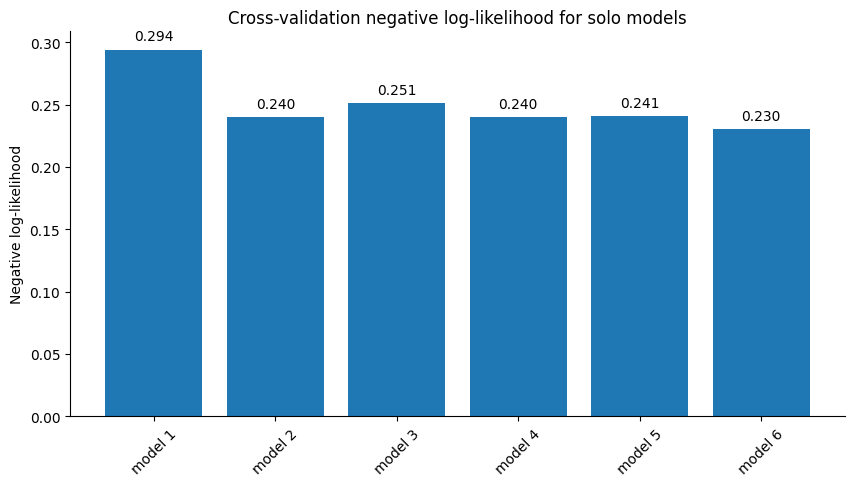

In [38]:
# plot nll barplot
plt.figure(figsize=(10, 5))
plt.bar(range(len(average_nlls)), average_nlls, tick_label=plotting_names)
plt.xticks(rotation=45)
plt.ylabel('Negative log-likelihood')
plt.title('Cross-validation negative log-likelihood for solo models')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Add values above bars
for i, value in enumerate(average_nlls):
    plt.text(i, value + 0.005, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

# plt.tight_layout()

In [122]:
cross_validation_datasets[5]["model_formula"]

'ChooseHigh ~ 1 + D2H + D2L + WallSep + (1|GlmPlayerID)'

In [123]:
### extract predictions and ground truth
predictions = [dataset['predictions'] for dataset in cross_validation_datasets]
df = cross_validation_datasets[0]['dataframe']
random_indices = cross_validation_datasets[0]['random_indices']

# extract the ground truth
ground_truth = []
for dataset in cross_validation_datasets:
    ground_truth.append(dataset['dataframe'].loc[random_indices]['ChooseHigh'].values)

In [ ]:
# combine each fold in the predictions field of the first dictionary in cross_validation_datasets
for i in range(1, len(predictions)):
    predictions[0]['predictions'] = np.concatenate((predictions[0]['predictions'], predictions[i]['predictions']), axis=0)

In [28]:
predictions_0_list = cross_validation_datasets[0]['predictions']
predictions_0 = np.array([])
for i in range(1, len(predictions_0_list)):
    predictions_0 = np.concatenate((predictions_0, predictions_0_list[i]), axis=0)

ground_truth_0_list = cross_validation_datasets[0]['split_df']
ground_truth_0 = np.array([])
for i in range(1, len(ground_truth_0_list)):
    ground_truth_0 = np.concatenate((ground_truth_0, ground_truth_0_list[i]['ChooseHigh']), axis=0)


In [42]:
predictions_5_list = cross_validation_datasets[5]['predictions']
predictions_5 = np.array([])
for i in range(1, len(predictions_5_list)):
    predictions_5 = np.concatenate((predictions_5, predictions_5_list[i]), axis=0)

ground_truth_5_list = cross_validation_datasets[5]['split_df']
ground_truth_5 = np.array([])
for i in range(1, len(ground_truth_5_list)):
    ground_truth_5 = np.concatenate((ground_truth_5, ground_truth_5_list[i]['ChooseHigh']), axis=0)

In [29]:
len(predictions_0), len(ground_truth_0)

(5266, 5266)

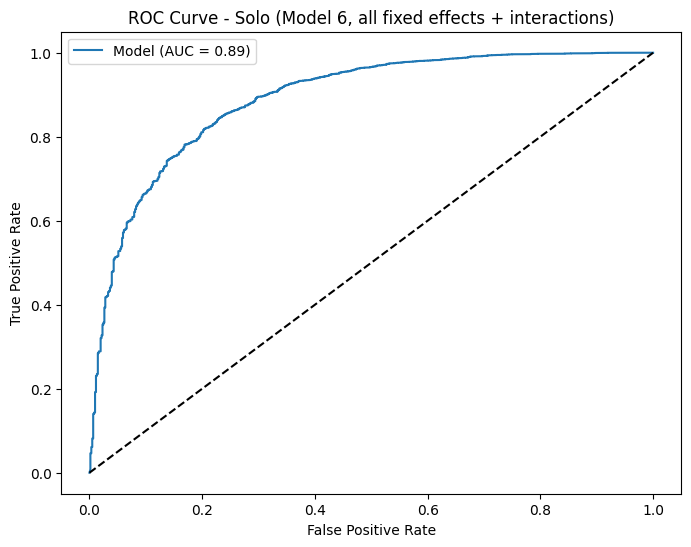

In [44]:
from sklearn.metrics import roc_curve, auc

# Example: Assuming `y_true` is the true labels and `y_scores` are model predictions
fpr, tpr, _ = roc_curve(ground_truth_5, predictions_5)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Solo (Model 6, all fixed effects + interactions)')
plt.legend()
plt.show()

## Solo-social

In [71]:
# load solo-social data from left-one-out cross-validation
data_folder = os.path.join('..','data')

CV_dataset_names = [
    file for file in os.listdir(data_folder) if file.startswith('CV_results_solo-social_') and file.endswith('.pickle')
]
print(CV_dataset_names)

ordered_datasets_names = CV_dataset_names

print(ordered_datasets_names)


cross_validation_datasets = [
    pd.read_pickle(os.path.join(data_folder, file)) for file in ordered_datasets_names
]


['CV_results_solo-social_randomintercepts_400.pickle', 'CV_results_solo-social_randomintercepts_interactions_400.pickle']
['CV_results_solo-social_randomintercepts_400.pickle', 'CV_results_solo-social_randomintercepts_interactions_400.pickle']


In [73]:
cross_validation_datasets[1]['model_formula']

'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + SocialContext + FirstSeenWall:SocialContext + D2H:SocialContext + D2L:SocialContext + (1 |GlmPlayerID)'

In [23]:
# create plotting names
plotting_names = [
    'rand intercepts',
    'interactions'
]

In [24]:
# extract and process nll
nlls = [ dataset['nll'] for dataset in cross_validation_datasets]

# divide nll by the number of models
nlls = [nll / len(dataset['random_indices']) for nll, dataset in zip(nlls, cross_validation_datasets)]

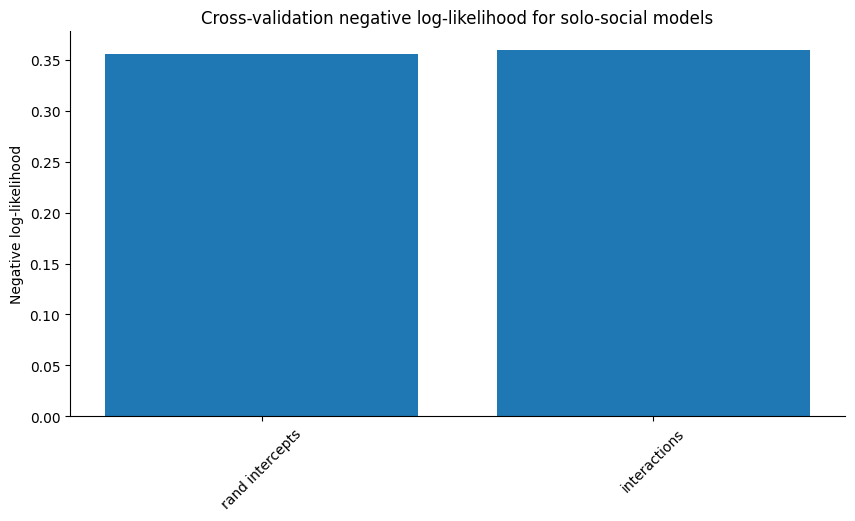

In [33]:
# plot nll barplot
plt.figure(figsize=(10, 5))
plt.bar(range(len(nlls)), nlls, tick_label=plotting_names)
plt.xticks(rotation=45)
plt.ylabel('Negative log-likelihood')
plt.title('Cross-validation negative log-likelihood for solo-social models')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# plt.tight_layout()

In [26]:
### extract predictions and ground truth
predictions = [dataset['predictions'] for dataset in cross_validation_datasets]
df = cross_validation_datasets[0]['dataframe']
random_indices = cross_validation_datasets[0]['random_indices']

# extract the ground truth
ground_truth = []
for dataset in cross_validation_datasets:
    ground_truth.append(dataset['dataframe'].loc[random_indices]['ChooseHigh'].values)

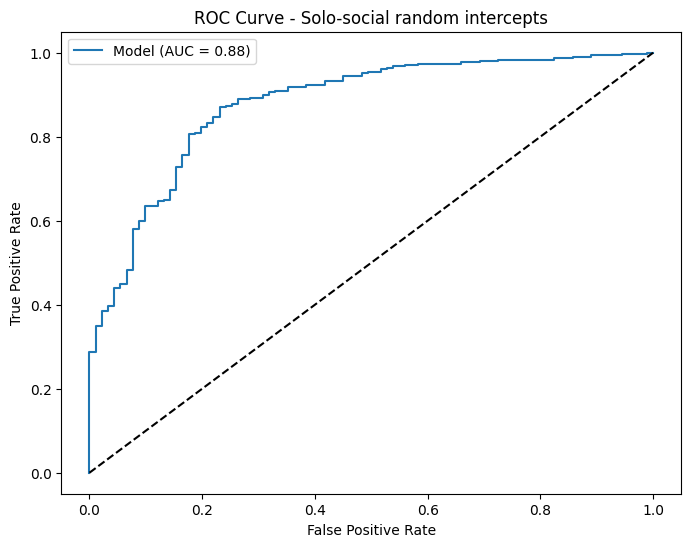

In [32]:
from sklearn.metrics import roc_curve, auc

# Example: Assuming `y_true` is the true labels and `y_scores` are model predictions
fpr, tpr, _ = roc_curve(ground_truth[0], predictions[0])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Solo-social random intercepts')
plt.legend()
plt.show()

## Social

In [126]:
# load solo-social data from left-one-out cross-validation
data_folder = os.path.join('..','data')

CV_dataset_names = [
    file for file in os.listdir(data_folder) if file.startswith('CV_results_social_') and file.endswith('.pickle')
]
print(CV_dataset_names)

ordered_datasets_names = [CV_dataset_names[0], CV_dataset_names[2], CV_dataset_names[1]]

print(ordered_datasets_names)


cross_validation_datasets = [
    pd.read_pickle(os.path.join(data_folder, file)) for file in ordered_datasets_names
]


['CV_results_social_randomintercepts_400.pickle', 'CV_results_social_randomintercepts_allinteractions_400.pickle', 'CV_results_social_randomintercepts_opponentvisible_400.pickle']
['CV_results_social_randomintercepts_400.pickle', 'CV_results_social_randomintercepts_opponentvisible_400.pickle', 'CV_results_social_randomintercepts_allinteractions_400.pickle']


In [128]:
cross_validation_datasets[2]['model_formula']

'ChooseHigh ~ D2H + D2L + FirstSeenWall + WallSep + OpponentD2H + OpponentD2L + OpponentFirstSeenWall + WallSep:FirstSeenWall + D2L:FirstSeenWall + D2H:FirstSeenWall +  (1 | GlmPlayerID)'

In [92]:
# create plotting names
plotting_names = [
    'rand intercepts',
    'rand intercepts w/o OpponentVisible',
    'interactions'
]

In [93]:
# extract and process nll
nlls = [ dataset['nll'] for dataset in cross_validation_datasets]

# divide nll by the number of models
nlls = [nll / len(dataset['random_indices']) for nll, dataset in zip(nlls, cross_validation_datasets)]

In [94]:
nlls

[np.float64(0.4699997629086861),
 np.float64(0.46896465335203724),
 np.float64(0.4612742022105404)]

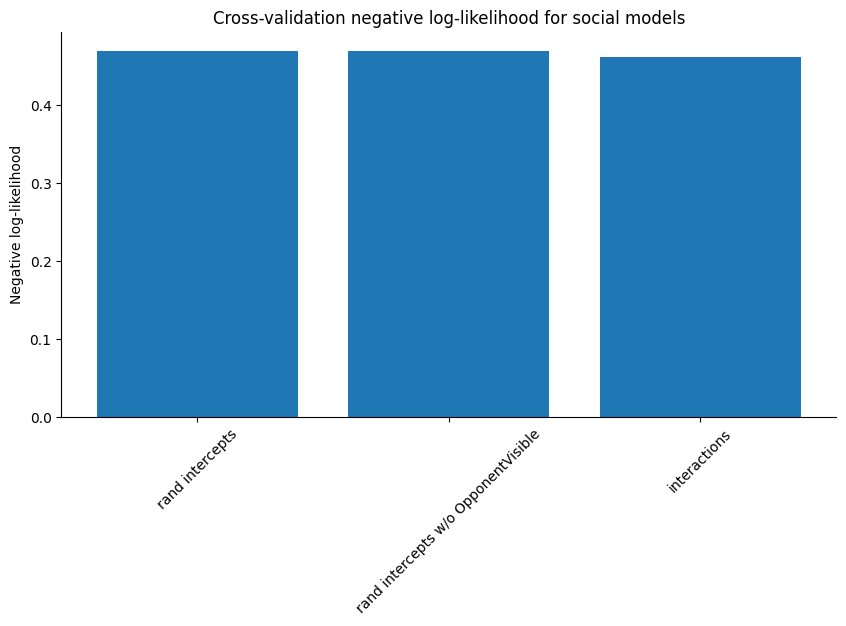

In [95]:
# plot nll barplot
plt.figure(figsize=(10, 5))
plt.bar(range(len(nlls)), nlls, tick_label=plotting_names)
plt.xticks(rotation=45)
plt.ylabel('Negative log-likelihood')
plt.title('Cross-validation negative log-likelihood for social models')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# plt.tight_layout()

In [96]:
### extract predictions and ground truth
predictions = [dataset['predictions'] for dataset in cross_validation_datasets]
df = cross_validation_datasets[0]['dataframe']
random_indices = cross_validation_datasets[0]['random_indices']

# extract the ground truth
ground_truth = []
for dataset in cross_validation_datasets:
    ground_truth.append(dataset['dataframe'].loc[random_indices]['ChooseHigh'].values)
    print(dataset['model_formula'])

ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + OpponentD2H + OpponentD2L + OpponentFirstSeenWall + (1|GlmPlayerID)
ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + OpponentVisible + OpponentD2H + OpponentD2L + OpponentFirstSeenWall + (1|GlmPlayerID)
ChooseHigh ~ D2H + D2L + FirstSeenWall + WallSep + OpponentD2H + OpponentD2L + OpponentFirstSeenWall + WallSep:FirstSeenWall + D2L:FirstSeenWall + D2H:FirstSeenWall +  (1 | GlmPlayerID)


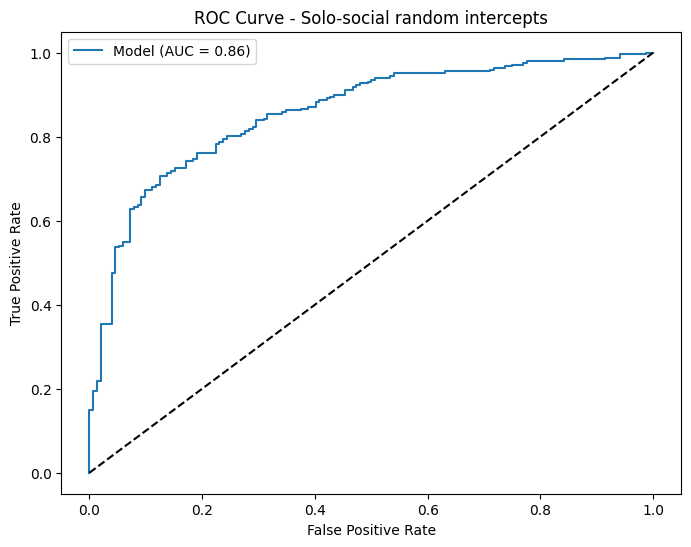

In [100]:
from sklearn.metrics import roc_curve, auc

# Example: Assuming `y_true` is the true labels and `y_scores` are model predictions
fpr, tpr, _ = roc_curve(ground_truth[2], predictions[2])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Solo-social random intercepts')
plt.legend()
plt.show()